In [73]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits 
from astropy.stats import * 
from photutils.background import Background2D, MedianBackground, MMMBackground
from photutils.detection import DAOStarFinder 
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry

In [2]:
#First define the image in python as a string.
imagefile = "M13_g_align.fit" 
image = fits.open(imagefile)[0].data
header = fits.open(imagefile)[0].header

In [3]:
print(image.shape)

(2042, 3054)


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_54057/1794141150.py:2: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.


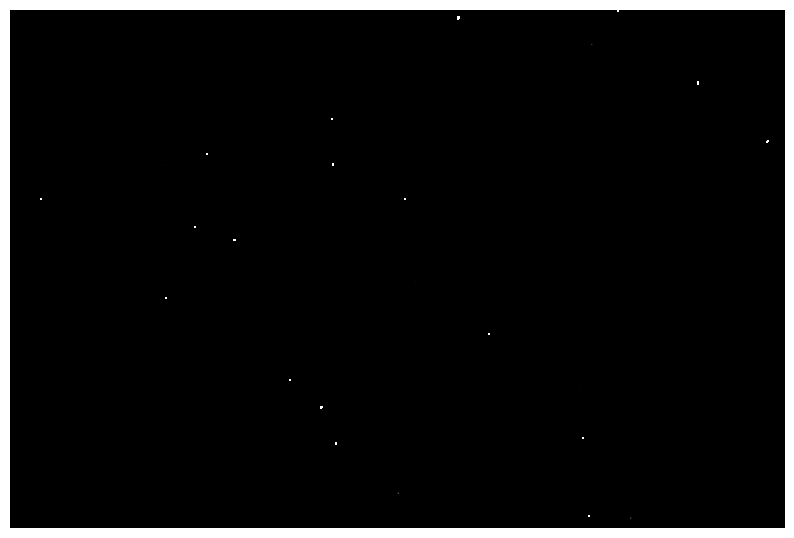

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), #We usually take the log of an image to see the variance of the pixels better.
            origin='lower', #This tells matplotlib where the [0,0] index is. For our images it is in the bottom.
            cmap = "gray", #Use whatever colormap you like, but I find gray the easiest to visualize.
            vmin = 6, vmax = 11) #This defines the data range we want to see. There are ways to automate this but I always do it manually.
plt.axis('off') #This removes the axes, which aren't really relevant for just viewing an image.
plt.show()

In [5]:
mjd = header['MJD-OBS']
print("The Modified Julian Date is", mjd)

The Modified Julian Date is 60067.9566047


In [122]:
sigma_clip = SigmaClip(sigma_lower=3.0,sigma_upper=np.inf, cenfunc='mean') 
mean, median, std = sigma_clipped_stats(image,sigma_lower=3.0,sigma_upper=np.inf, cenfunc='mean') 

bkg_estimator = MedianBackground() 
bkg = Background2D(image, 
                    box_size=(20, 20), 
                    filter_size=(9, 9), 
                    sigma_clip=sigma_clip, 
                    bkg_estimator=bkg_estimator) 
bkg_median = bkg.background_median
bkg_rms = bkg.background_rms_median

mmm_bkg = MMMBackground()

daofind = DAOStarFinder(fwhm=0, #This is the full width half maximum of the 'gaussian kernel' of the starfinder in units of pixels. Smaller values will find more sources, large values will find less.
                        #threshold=2*mmm_bkg(image))
                        threshold=std*5,
                        brightest= 18) #The threshold determines at what pixel value the starfinder will call something a source. We usually use a multiple of the standard deviation we found earlier. Again smaller for more.
sources = daofind(image) #We subtract the median we found earlier from the whole image.
print(sources)

/Users/klin/miniforge3/envs/phys240/lib/python3.10/site-packages/photutils/detection/core.py:226: RuntimeWarning: divide by zero encountered in double_scalars
  self.a = (cost**2 / (2.0 * xsigma2)) + (sint**2 / (2.0 * ysigma2))
/Users/klin/miniforge3/envs/phys240/lib/python3.10/site-packages/photutils/detection/core.py:226: RuntimeWarning: invalid value encountered in double_scalars
  self.a = (cost**2 / (2.0 * xsigma2)) + (sint**2 / (2.0 * ysigma2))


ZeroDivisionError: float division by zero

In [109]:
print(mean, median, std, sorted(image.flatten(),reverse=True)[:10])
print(bkg_median,bkg_rms)
print(np.where(image==image.max()))
print(np.nanstd(image))

35.761032 34.817314 16.17389 [12016.246, 9657.141, 8506.014, 7583.569, 7277.139, 6150.875, 5335.5176, 4966.7563, 4797.4956, 4046.3286]
34.62729835510254 3.4526005782228575
(array([1749]), array([2711]))
16.197168


/var/folders/ts/_gjzk30d5ggbnzxtbzmvs2240000gn/T/ipykernel_54057/214992079.py:6: RuntimeWarning: invalid value encountered in log
  plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)


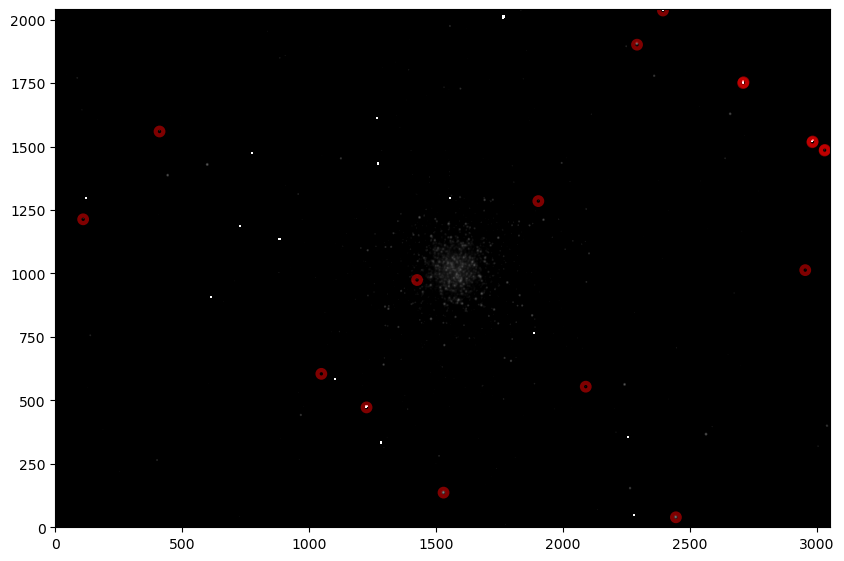

In [121]:
positions = np.transpose((sources['xcentroid'], sources['ycentroid'])) #Positions are transposed by default.
apertures = CircularAperture(positions, r=15) #This defines an 'aperture' by radius around each source. The pixel values inside the aperture are summed to yield the photon count of the star.

#Lets plot our image again with the apertures overplotted to see how many stars we found.
plt.figure(figsize=(10,10))
plt.imshow(np.log(image), origin='lower', cmap = "gray", vmin=4, vmax = 11)
v = apertures.plot(color='red', lw=3, alpha=0.5) #I define it as a variable to avoid unnecessary readout.
plt.show()